<a name="cell-TOC"></a>
### 2. [Modeling ${\rm I\!R}$ with ${\rm I\!F}$](#cell-FPN-FR)
0. [Accuracy Limits: Root-Finding with Bisection](#cell-FPN-FR)
1. [Density of ${\rm I\!F}$](#cell-FPN-dense)
2. [Overflow](#cell-FPN-numovr) and [Underflow](#cell-FPN-numndr)
  0. [The `log` trick](#cell-FPN-dense-tricks)
3. [Roundoff Error](#cell-FPN-roundoff): Week 2 Programming Assignment Problem 1
  0. [Taylor Series Expansions](#cell-FPN-dense-taylor)
  1. [Machine-Epsilon $\epsilon_{machine}$ and Error Accumulation](#cell-FPN-machine-epsilon)
  2. [Symplectic Integration](#cell-FPN-HMC)
4. [Catastrophic Cancellation](#cell-FPN-catacan): Week 2 Programming Assignment Problem 2
  0. [The Quadratic Formula](#cell-FPN-quadratic-formula)
5. [OPTIONAL] [Digital VS Analog Computing](#cell-DvsA) 
6. [OMITTED] ~[Bit Arithmatic](#cell-FPN-bit-mult)~ 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.style.use('ggplot')

In [3]:
# Look at the code below first before looking at
# the details of this function if you are intersted 
def bisection_root_finder(f, a, b, steps, ax=None):
  """
    Find a root of a function with the bisection method
    f: target function
    a: initial left bound
    b: initial right bound

    f(a) and f(b) must have different signs so we know they bound 0!
  """

  if ax:
    f_min = np.min([f(a),f(b)])
    f_max = np.max([f(a),f(b)])
    xs = np.linspace(a, b, 100) 
    ax.plot([a,b], 2*[0], 'k--')
    ax.plot(xs, f(xs))

  for i in range(steps):

    if ax:
      ax.plot([a,b], 2*[f_max - (i-1)*(f_max-f_min)/(steps-1)], 'k')
      ax.text(a, f_max - (i-1)*(f_max-f_min)/(steps-1), '|', ha='right', va='center')
      ax.text(b, f_max - (i-1)*(f_max-f_min)/(steps-1), '|', ha='left', va='center')
      # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html

    if np.sign(f(a)) == np.sign(f(b)):
      print("Something Unexpected Happened")
    else:
      #if f(a) * f(a + (b_a)/2) <= 0: # <- could underflow
      if np.sign(f(a)) == np.sign(f(a + (b-a)/2)): 
        a = a + (b-a)/2 
      else:
        b = b - (b-a)/2
        # We do not update the midpoint as (a+b)/2
        # because (as we shall see next) the above
        # operations have more numerical precision

  return a+(b-a)/2, f(a+(b-a)/2)

<a name="cell-FPN-FR"></a>

# 2. Modeling ${\rm I\!R}$ with ${\rm I\!F}$ ([Return to TOC](#cell-TOC))
---


${\rm I\!F}$ is just a model for ${\rm I\!R}$. ${\rm I\!F}$ is not ${\rm I\!R}$ since generally the ***floating-point*** representation `x`$=[x]_c \not = x$ the actual ***real*** number; hence, we need to use ${\rm I\!F}$ carefully when we wish to carry out ${\rm I\!R}$-like operations on a computer. 

> *Computer numbers are not the same as real numbers, and the arithmatic operations on computer numbers are not exactly the same as those of ordinary arithmetic*. 
>
> *The form of a mathematical expression and the way the expression should be evaluated in practice may be quite different.*
>
> -- James E. Gentle, Statistical Computing






# 2.0 Accuracy Limits: Root-Finding with Bisection ([Return to TOC](#cell-TOC))

---

The ***bisection method*** is a simple method for finding the roots of *continuous* functions. Here's the algorithm of the ***bisection method***. 

```python
# initialize `a` and `b` such that f(a) and f(b) 
# have different signs so we know they bound 0!
# then
for i in range(steps):
    if np.sign(f(a)) == np.sign(f(a + (b-a)/2)): 
        a = a + (b-a)/2 
    else:
        b = b - (b-a)/2
```

Like all numerical methods, the the ***bisection method*** is contrained by the limitations of the floating-point number system ${\rm I\!F}$. The example below shows that for the function 

$$f(x) = \frac{1 + 1/x - \log(x)}{(1+x)^2}$$

the numerically closest to the root in ${\rm I\!F}$ that we can find is

$$f(x= \texttt{3.591121476668622}) = \texttt{1.0534226635121335e-17} \not = 0$$

even though there does indeed exist an $x^* \in {\rm I\!R}$ such that $f(x^*) = 0$.

In [266]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

# f = lambda x: x**3 - 4*x**2 + 18*x -115
f = lambda x: (1 + 1/x - np.log(x))/(1+x)**2

bisection_root_finder(f, a=1, b=5, steps=12, ax=ax)
_ = ax.set_title('Bisection Method')
print('(x,                 f(x)                  )')
print(bisection_root_finder(f, a=1, b=5, steps=50))
print(bisection_root_finder(f, a=1, b=5, steps=100))
print(bisection_root_finder(f, a=1, b=5, steps=150))

- Further considerations of the ***bisection method*** are given in the "Bisection" Section ([Section 9.1.0](#cell-opt-fx-bisection)). 

*This example is inspired by Chapter 2.1 **Univariate Problems** of Givens and Hoetings (pages 22-26), Chapter 3.3 [**Interval Bisection Method**](https://www.tf.uni-kiel.de/matwis/amat/comp_math/kap_1/backbone/r_se19.html) in J. Carstensen and J. M. Wagner's [**Computer Matematics**](https://www.tf.uni-kiel.de/matwis/amat/comp_math/), and the **Bisection Method** Section in Chapter 6.1 **Finding Roots of Equations** of Gentle (pages 246-248). [Errata Warning: on page 25 Givens and Hoeting report that bisection works for continuous $g'$, which is true; but, more generally bisection works for finding zeros of continuous functions $g$; and in Algorithm 6.2 **Bisection to Find a Root of an Equation** on page 247, Gentle does not point out that there is more numerical precision in the updates $a+(b-a)/2$ or $b-(b-a)/2$ rather than $(a+b)/2$ as pointed out by Givens and Hoetings on page on page 25.]*

<a name="cell-FPN-dense"></a>

# 2.1 Density of ${\rm I\!F}$ ([Return to TOC](#cell-TOC))
---

${\rm I\!F}$ is not ***dense*** like ${\rm I\!R}$, it's ***exponentially sparse***.

For integer $p$ such that $|p| \leq 1023$, suppose

- $y = 2^p\times(2 + \sum_{i=1}^{51} 2^{-i})$
- $y_{next} = 2^p\times(2 + \sum_{i=1}^{52} 2^{-i})$

so that $y_{next} = y + u$ where $u = 2^p \times 2^{-52}$ (or $2^{-1023} \times 2^{-51}$ during *graceful underflow*). The $y$, $y_{next}$, and $u$ are all in ${\rm I\!F}$, and the $u$ is the smallest possible increase in $y$ that is reprsentable in ${\rm I\!F}$. In *base $10$* representation 
$$u = y_{next} - y \approx 10^{q-16}$$

where $10^q = 2^p$ and $2^{-52} \approx 10^{-16}$ (or $2^{-51} \approx 10^{-16}$).

The $u$ is called the **"ulp"** (the "unit in the last place"), and it dictates the spacing between neighboring ***floating-point numbers***: the larger the magnitude of $p$ (or $q$), the farther away $y_{next}$ is from  $y$. 

> For ***floating-point numbers*** $y \approx 10^q$ and $y' \approx 10^{q+1}$, $y_{next}-y\approx 10^{q-16}$ and $y'_{next}-y'\approx 10^{q-15}$ so as ***floating point numbers*** grow exponentially larger, they also grow exponentially farther apart.  Unlike the real-numbers ${\rm I\!R}$, floating-point numbers ${\rm I\!F}$ are exponentially increasingly sparse (i.e., farther away from each other) the further away from zero they get. 
>
> - Below this is demonstrated using the `np.spacing` function which will "Return the distance between x and the nearest adjacent number" and the `np.nextafter` function which will "Return the next floating-point value after x1 towards x2, element-wise".

In [267]:
# http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(11,5.5))

n,p = 30, 100
grid = np.logspace(start=0, stop=p, num=n, base=10.0) # np.logspace?

# https://stackoverflow.com/questions/773814/plot-logarithmic-axes-with-matplotlib-in-python
# https://matplotlib.org/stable/tutorials/introductory/pyplot.html#logarithmic-and-other-nonlinear-axes
ax[0].plot(np.log10(grid), grid, '.'); ax[0].set_yscale('log') #fig.yscale('log')
ax[0].set_ylabel('Floating-Point number'); ax[0].set_xlabel('p in 10^p')

# https://numpy.org/doc/stable/reference/generated/numpy.spacing.html#numpy.spacing
ax[1].plot(np.spacing(grid), grid, '.'); ax[1].set_xlabel('Distance')
ax[1].set_title('Distance to Next Respresented Floating-Point')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
plt.tight_layout()

In [267]:
# https://numpy.org/doc/stable/reference/generated/numpy.nextafter.html#numpy.nextafter
# np.nextafter: "Return the next floating-point value after x1 towards x2, element-wise"
starting_float = 0.
#starting_float = 1e-100
#starting_float = 1e-30
#starting_float = 1.
#starting_float = 10.
#starting_float = 1e+10
#starting_float = 1e+20
#starting_float = 1e+30
#starting_float = 1e+100
#starting_float = 1.7976931348623157e+307
distance_to_next_float = np.nextafter(starting_float, np.Inf) - starting_float
"next float from", starting_float, "is", distance_to_next_float, "away"

<a name="cell-FPN-numovr"></a>

# 2.2 Overflow ([Return to TOC](#cell-TOC))

---

The production of a `Inf` from numeric values is called ***overflow***.
> ***Overflow*** happens when the magnitude of a number is greater than the largest representable ***floating-point*** number; whence, either an error or warning is produced or the number is represented as `Inf` (or both) and the information in the number is lost.

In [267]:
print(2. * 1.7976931348623157e+308)
print(type(2. * 1.7976931348623157e+308))
# Note that this does not report an error like `10.**309` did
# And compare this to: `2. * np.finfo(float).max`, with type `numpy.float64`

In [267]:
# These differences shows that different "types" of floating-point numbers 
# don't necessarily all treat overflow encounters the same way(!)
#np.finfo(float).max
#type(np.finfo(float).max)
#2. * np.finfo(float).max
#10.**309

Remember the "0" in the largest possible 64-bit floating point number `1.7976931348623157e+308`?

In [267]:
! pip install bitstring # install a package not immediately available

In [267]:
import bitstring
# 1.7976931348623157e+308 is the largest representable floating point number
print(bitstring.BitArray(float=1.7976931348623157e+308, length=64).bin)
print(" ... that ^0^ there ...")
print("                        which is the last digit of the exponent...")

Here's what happen's if that `0` becomes `1` (so that all exponent bits are `1`):

In [267]:
print('   1.7976931348623157e+308 + 1e+292')
print("= ", bitstring.BitArray(float=1.7976931348623157e+308, length=64).bin)
print(" +", bitstring.BitArray(float=2**1023 + 2**1022, length=64).bin)
print('= ', 1.7976931348623157e+308 + 2**1023)
print("= ", bitstring.BitArray(float = 1.7976931348623157e+308 + 2**1022, length=64).bin)
print(" no zero here ^ any more")
print("    but also all the significand bits don't matter any more and get set to 0")

Of course, so long as the value has not yet reached infinity, then all the *significand* digits are tracked:

In [267]:
# just picking some arbitrary numbers to add together... 
print(" ", bitstring.BitArray(float=.89e+308, length=64).bin)
print("+", bitstring.BitArray(float=.89e+308, length=64).bin)
print("=", bitstring.BitArray(float=.89e+308+.89e+308, length=64).bin)
print("=", .89e+308+.89e+308)

<a name="cell-FPN-numndr"></a>
# 2.2 Underflow ([Return to TOC](#cell-TOC))

---

The sitution where a ***floating-point*** representation of a number in $I \!\! F$ is $[x]_c = 0$ when the number in ${\rm I\!R}$ is $x \neq 0$ in ${\rm I\!R}$ is called ***underflow***.

> ***Underflow*** happens when a ***floating-point*** number is closer to `0` than the smallest representable non zero ***floating-point*** that can be represented;
 whence, either an error or warning is produced or the number is represented as a `0.0` (or both) and the information in the number is lost.

It's easier to notice when an ***overflow*** occurs since the presence of an `Inf` in an arithmetic operation will be persistent (e.g., `Inf + c = Inf`) whereas the presence of a `0.0` may not be (e.g., `0.0 + c = c`). This means than an ***underflow*** to $0$ is particularly concerning because unlike an ***overflow*** producing `np.Inf` the $0$ can easily go unnoticed. This can be addressed if error or warning messages are raised when ***underflow*** and ***overflow*** occur; however, making use of these messages requires checking them constantly.

In [267]:
print(' ', '1.7976931348623157e-308 * 1.7976931348623157e-308')
print('=', bitstring.BitArray(float=1.7976931348623157e-308, length=64).bin, '*', 
      bitstring.BitArray(float=1.7976931348623157e-308, length=64).bin)
print('=', 1.7976931348623157e-308*1.7976931348623157e-308)
print('=', bitstring.BitArray(float=1.7976931348623157e-308*1.7976931348623157e-308, length=64).bin)

The smallest number greater than $0$ we can represent, using the ***unnormalized*** representation of the "graceful underflow trick" (where when $p=−1023$ and the leading *hidden digit* is taken to be `0`) is

In [267]:
print(np.nextafter(0., 1.))
print(bitstring.BitArray(float=np.nextafter(0., 1.), length=64).bin)

In [267]:
# The largest number number representable using graceful underflow is
print(np.nextafter(2**-1022., 0.))
print(bitstring.BitArray(float=np.nextafter(2**-1022., 0.), length=64).bin)

<a name="cell-FPN-dense-tricks"></a>
## 2.2.0 The `log` trick ([Return to TOC](#cell-TOC))

---

***Overflow*** and ***underflow*** limits bound computation, but not in the same way. Because of the exponentially sparse density of ***floating-point representations***, numeric imprecision increases with the magnitude of $x$. Thus, numeric resolution is better near `0` (as long as an unnoticed ***underflow*** does not occur). The obvious way place numeric computations closer to `0` is to work on a $\log$ scale, since this means

$$\text{multiplication $\longrightarrow$ addition} \quad\quad\text{ and }\quad\quad \text{division $\longrightarrow$ subtraction}$$

Many functions can greatly extend their computational applicability by working on the log scale and taking advantage of the increased precision numerical precision near `0`. 

For example, for large inputs, the factorial function and gamma functions 
- `scipy.special.gammaln` 
- `scipy.special.loggamma` 

can only be used on log scales (where they can be useful, e.g., in log-likelihoods). 

Sometimes, even if a computation `<x>` ***underflows*** or ***overflows***, the calculation re-expressed in log space as `<logx> =` $\log( <\!x\!> )$ may not; and, subsequently `exp(logx)` also may not. And even if the `<x>` computation doesn't ***underflow*** or ***overflow***, the alternative log space computation may still over increased precision relative to that naive computation on the original scale. 

> Any function $f$ on $[0,1]$ may be approximated to arbitrary accuracy with ***Bernstein polynomials***
>
> $$f(x) \approx \sum_{k=0}^m f\left(\frac{m}{k}\right) p_{mk}(x)$$
> where 
>
> $$\begin{align*}
p_{mk}(x) = {} & \left(\begin{array}{c}m\\k\end{array}\right) x^k (1-x)^{m-k} \\
 = {} & \exp\left(\log \left(\begin{array}{c}m\\k\end{array}\right) + k \log(x) + (m-k)\log(1-x) \right)
\end{align*}$$
> 
> and only the $\log$ scale leads avoids ***underflow*** and ***overflow*** for large $m$.
>
> - *This example is taken from Keith Knight's STA410 [notes1.pdf](https://q.utoronto.ca/courses/296804/files?preview=24222782) document*. 


<a name="cell-FPN-roundoff"></a>

# 2.3 Roundoff Error ([Return to TOC](#cell-TOC))

---

$1.234567891011121 \times 10^{300} + 100000000000$ is a real number which cannot be represented in the ***floating-point*** number system.

The computer representation $[\cdot]_c$ of our number is

$$[1.2345678910111213 \times 10^{300} + 100000000000]_c = 1.234567891011121 \times 10^{300}$$

which is the closest number representation ***floating-point*** can provide and which has a ***roundoff error*** of $100000000000$.

In [267]:
1.234567891011121e+300 + 100000000000.

Floating-point numbers retain the 16 most significant digits, followed or preceeded by a sequence of zeros contributed from the $2^{exponent}$ multiplier.  

> In the above example, `1234567891011121` is followed by 285 zeros, and only those first significant digits, i.e., `1234567891011121`, are retained in a ***floating-point*** system.  So when `100000000000` is added to that, it's way down past the 16 most significant digits and is immediately lost since it does not contributed any significant digits in the ***floating-point*** representation.

1. "Big" floating-point numbers dominate and overshadow "small" floating-point numbers making the contributrion of "small" floating-point so insignificant that they get "lost".
2. Floating-point representations do not have enough precision to track small decimal values in the presense of much larger magnitude numbers.
3. Only similiar magnitude ***floating-point*** numbers can be arithmetically combined without inducing **roundoff** error.

- [Week 2 Programming Assignment Problem 1]() will examine ***roundoff error*** in the familar context of *addition*.  You may be surprised to find out that these simple and routine calculation are actually at grave risk for these numerical maladies when ${\rm I\!F}$ is not used carefully for modeling calculations in ${\rm I\!R}$.

<a name="cell-FPN-dense-taylor"></a>

## 2.3.0 Taylor Series Expansions ([Return to TOC](#cell-TOC))
--- 

> *The examples in this section are is taken from Keith Knight's STA410 [notes1.pdf](https://q.utoronto.ca/courses/296804/files?preview=24222782) document*. 

The ***Taylor Series*** of $f(x)$ expanded around $x_0$ is

$$f(x) = \underset{f^{(k)} \text{ is the } k^{th} \text{derivative of } f}{\sum_{k=0}^{\infty} \frac{f^{(k)}(x_0)}{k!}(x-x_0)^k}$$

so that, e.g., the ***Taylor Series*** of $e^x$ expanded around $0$ is

$$\begin{align*}e^x  & = {} e^0 + e^0(x-0) + \frac{e^0}{2}(x-0)^2 + \frac{e^0}{3!}(x-0)^3 + \cdots \\
& = {} 1 + x + \frac{x^2}{2} + \frac{x^3}{3!} + \cdots \end{align*}$$

Another example is $\ln(1+x) = x - \frac{x^2}{2} + \frac{x^3}{3} + \cdots$.

In [267]:
def taylors_e(x, approximation_limit=100, verbose=False):
  """
    Taylor Series Approximation of e^x
    using approximation_limit (default 100) terms
  """ 
  series = np.zeros(approximation_limit)
  xi, ifac, ex =  1., 1., 1. 
  for i in range(approximation_limit):
    xi *= x
    ifac *= (i+1)
    ex += xi/ifac
    if verbose:
      series[i] = ex
  if verbose:
    return series
  return ex

# np.exp(-50) is numerically accurate, but only `1/taylors_e(50)` is comparable
np.exp(-50), taylors_e(-50), 1/taylors_e(50) # `taylors_e(-50)` doesn't work

- `1/taylors_e(50)`: works because the summation accumulates values from smallest to largest magnitude and thereby retaining the contribution of the early summands in aggregate, and then the reciprocal is a value "close" to `0` where the ***floating-point*** numbers ${\rm I\!F}$ are the most dense and offer better numeric representation

- `taylors_e(-50)` struggles because the alternatingly signed terms result in a "cancelled out" summation of smaller magnitude relative to the increasingly larger terms and so this cumulative contribution is increasingly lost due to the ***roundoff error*** inherrent in mismatched magnitude summands.

In [267]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
x=50
ax[0].plot(taylors_e(-x, approximation_limit=100, verbose=True), label='$e^{-'+str(x)+'}$')
ax[1].plot(taylors_e(x, approximation_limit=100, verbose=True), label='$e^{'+str(x)+'}$')
ax[2].plot([0,99], 2*[-x], label='Truth')
ax[2].plot(np.log(1./taylors_e(x, approximation_limit=100, verbose=True)), label='$\\log(1/e^{'+str(x)+'})$')
ax[0].legend(); ax[1].legend(); ax[2].legend()
ax[0].set_xlabel("Not good: rapidly oscilating cumulative sum")
ax[2].set_title("Good: smooth numerical convergence to truth")
_ = ax[1].set_xlabel("Numer of Terms in Taylor Series Approximation")

In [267]:
x = 50
taylors_e(-x, approximation_limit=100, verbose=True)[-1], 1/taylors_e(x, approximation_limit=100, verbose=True)[-1]
# Notice how the rapidly oscilating sum ends up way wrong compared to what it should be
# The earlier summation contributions that would have corrected have been lost to roundoff error

Here's another example.

In [267]:
# The Taylor series approximation avoids roundoff error and underflow for small magnitude x 
# since small x values won't don't matter in higher order terms of the approximation
x = np.logspace(-20,-10,100)
plt.figure(figsize=(12,6))
plt.plot(x, (np.exp(x)-1)/x, label="$\\frac{e^x-1}{x}$ evaluation (small $x$ fails)")
f = lambda x: 1 + x/2 + x**2/6 + x**3/24 # higher order terms don't matter if x is small
plt.plot(x, f(x), label="Taylor series approximation")
_ = plt.xscale("log"); plt.legend(prop={'size': 20})
# The roundoff error affects np.exp(x) for 1e-16 < x < 1e-13
# For x < 1e-16 the problem is underflow where x is numerically 0 so np.exp(x) is 1

In [267]:
# Roundoff error affects np.exp(x) for 1e-16 < x < 1e-13
x = 1e-15
print("x is:             ", x)
print("or, more exactly")
print(bitstring.BitArray(float=x, length=64).bin, "\n")
print("np.exp(x) is:     ", np.exp(x))
print("or, more exactly")
print(bitstring.BitArray(float=np.exp(x), length=64).bin)
print(' which doesn\'t have enough bits to be accurately represented ^^^^^^ (but it happens to have "rounded up" here)')
print("Roundoff error!\n")

print("So np.exp(x)-1.0 is: ", np.exp(x)-1.0)
print("when it should be much close to: ", x)
print("so roundoff error is:", (np.exp(x)-1.0)-x, "\n")

print("Not much but the ratio is now quite a bit larger than 1!")
print((np.exp(x)-1.0)/x)

In [267]:
# For x < 1e-16 the problem is the underflow where x is numerically 0 so np.exp(x) is 1
1e-16, np.exp(1e-16)

<a name="cell-FPN-machine-epsilon"></a>

## 2.3.1 Machine-Epsilon $\epsilon_{machine}$ and Error Accumulation ([Return to TOC](#cell-TOC))
---

> *The presentation in this section is taken from Keith Knight's STA410 [notes1.pdf](https://q.utoronto.ca/courses/296804/files?preview=24222782) document*. 

As should be clear, there are limits to how well ${\rm I\!F}$ can approximate ${\rm I\!R}$. This turns out to be even more true as a result of the fact that numerical errors accumulate and compound. Thus, the error added from each step in a sequential process needs to be minimized. 

***Resolution*** (e.g., `1e-15`) tells you the last significant digit not subect to numerical imprecision, but an [alternative characterization](https://stackoverflow.com/questions/9528421/value-for-epsilon-in-python/9528651) of ***numerical precision*** is ***machine-epsilon*** $\epsilon_{machine}$ 

```python
> np.finfo(float).eps
2.220446049250313e-16 # 2**-52 smallest value representable in the significand
```

which bounds numeric imprecision as

$$[|x|]_c \leq |x|(1+\epsilon_{machine})$$

In the case of addition, the ***machine-epsilon*** characterization

$$[x]_c = x(1 + \epsilon), |\epsilon| \leq \epsilon_{machine}$$

leads to a prescriptive instruction regarding the best order of operations, since

$$
\begin{align*}
[x_1+x_2]_c = {} & (x_1+x_2)(1+\epsilon_1)\\
[(x_1+x_2)(1+\epsilon_2) + x_3]_c = {} & ((x_1+x_2)(1+\epsilon_1)+x_3)(1+\epsilon_2)\\
\vdots \; {} & \\
\left[\sum_{i=1}^n x_i\right]_c = {} & \left[(x_1+x_2)\prod_{i=1}^{n-1} (1+\epsilon_i)\right] + \left[x_3 \prod_{i=2}^{n-1} (1+\epsilon_i)\right] + \cdots + \left[x_n(1+\epsilon_{n-1})\right]\\
\text{drop higher order terms} \quad \Longrightarrow \quad \approx {} & (x_1+x_2)\left(1+\sum_{i=1}^{n-1} \epsilon_i\right) + x_3 \left(1 + \sum_{i=2}^{n-1} \epsilon_i\right) + \cdots + x_n(1+\epsilon_{n-1})\\
= {} & \underset{\text{true value}}{\sum_{i=1}^{n} x_i} + \underbrace{\sum_{j=1}^{n-1} \left(\epsilon_j\sum_{i=1}^{j+1}x_i\right)}_{\text{numerical error}}
\end{align*}
$$

which shows that the numerical error at step $j$ in the sum depends on the multiplication $\epsilon_j\sum_{i=1}^{j+1}x_i$. Thus, if the smaller terms are added together first, then the numerical error from each $\epsilon_j$ is smaller since $\sum_{i=1}^{j+1}x_i$ is smaller. Thus, the numerical errors accumulate more slowly and there is less error overall if we sum smaller numbers first.

> The ***machine-epsilon*** perspective characterizes ***catastrphic cancelation*** as
> 
> $$\begin{align*}
0 = [x_1]_c - [x_2]_c = {} & x_1(1+\epsilon_1) - x_2(1+\epsilon_2)\\
= {} & \underbrace{x_1 - x_2}_{\not = 0} + \underbrace{x_1\epsilon_1- x_2\epsilon_2}_{= -(x_1-x_2)}
\end{align*}$$
>
> which shows that the problem happens when the true difference $x_1 - x_2$ and the numerical error $x_1\epsilon_1- x_2\epsilon_2$ have identical magnitudes. Since $\epsilon_1$ and $\epsilon_2$ have small magnitudes, it thus follows then that ***catastrphic cancelation*** can only occur if
> - $|x_1|$ and $|x_2|$ are large 
> - while $|x_1 - x_2|$ is small 
> 
> so that $|x_1\epsilon_1- x_2\epsilon_2| = |x_1 - x_2|$.

<a name="cell-FPN-HMC"></a>

## 2.3.2 Symplectic Integration ([Return to TOC](#cell-TOC))

---

Consider the *energy* function $H(\theta, v)$ made from the *potential energy* $U(\theta)$ and *kinetic energy* $K(v)$ 

$$H(\theta, v) = U(\theta) + K(v)$$

which is proportional to a log likelihood of an independent joint distribution  

$$H(\theta, v) \propto \log p(\theta, v) = \log[q(\theta)h(v)], \theta \perp\!\!\!\perp v$$

such as an independent normal distribution, in which case

$$ U(\theta) = \frac{1}{2}\theta^2 \quad \text{ and } \quad K(v) = \frac{1}{2}v^2$$

In this context, ***conservation of energy*** means $\theta + v$ remains constant, and ***Hamiltonian dynamics*** evolves $\theta$ and $v$ over time $t$ according to the differential equations

\begin{align*} \frac{d\theta}{dt} & = {} \frac{dH}{dv} & \frac{dv}{dt} & = {}  -\frac{dH}{d\theta} \\ & = {} \frac{dK}{dv} = v & & = {}   -\frac{dU}{d\theta}= -\theta  \end{align*}

which ensures this is true since it specifies that every changes in $\theta$ and $v$ is equal and opposite. 

The solutions to these differential equations for the $U(\theta)$ and $K(v)$ specifications above have the form 


$$ \theta(t) = r \cos(a + t) \quad \text{ and } \quad v(t) = -r \sin(a + t) $$

and for $r=1$ and $a=0$, each $\theta(t)$ and $v(t)$ will lie on the unit circle.

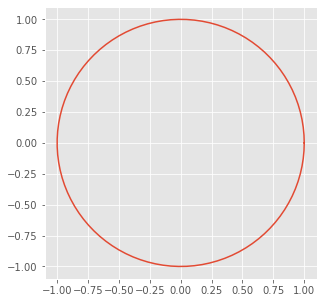

In [269]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
t = np.linspace(0,2*np.pi, 100)
ax.plot(np.cos(t), -np.sin(t)); ax.set_aspect('equal', adjustable='box') # https://www.delftstack.com/howto/matplotlib/how-to-make-a-square-plot-with-equal-axes-in-matplotlib/

The following options numerically approximate the solution trajectory of a differential equations.  These processes are referred to as ***integration*** because they add up all changes over time to determine the evolution of the proceess (like adding up areas under a curve in integration).

1. ***Euler's method***: not a ***symplectic integrator***

| | | | | |
|-|-|-|-|-|
|| $ \Large \begin{align*} 
\theta(t+\epsilon) & = {} \theta(t) + \epsilon \frac{d\theta(t)}{d t}\\
& = {} \theta(t) + \epsilon v(t)
\end{align*}$ | $\quad$ | $ \Large \begin{align*} 
v(t+\epsilon) & = {} v(t) + \epsilon \frac{dv(t)}{d t}\\
& = {} v(t) - \epsilon \theta(t)
\end{align*}$ ||

2. ***Euler's method*** (***improved variant***): a ***first order symplectic integrator***

| | | | | |
|-|-|-|-|-|
|| $ \Large \begin{align*} 
\theta(t+\epsilon) & = {} \theta(t) + \epsilon \frac{d\theta(t)}{d t}\\
& = {} \theta(t) + \epsilon v(t)
\end{align*}$ | $\quad$ | $ \Large \begin{align*} 
v(t+\epsilon) & = {} v(t) + \epsilon \frac{dv(t+\epsilon)}{d t}\\
& = {} v(t) - \epsilon \theta(t+\epsilon)
\end{align*}$ ||

3. The ***leapfrog method*** (or ***leapfrog integration***): a  ***second order symplectic integrator***

| | | | | |
|-|-|-|-|-|
|| $ \Large \begin{align*} 
\theta(t+\epsilon/2) & = {} \theta(t) + \frac{\epsilon}{2} \frac{d\theta(t)}{d t}\\
& = {} \theta(t) + \frac{\epsilon}{2} v(t)
\end{align*}$ | $\quad$ | $ \Large \begin{align*} 
v(t+\epsilon) & = {} v(t) + \epsilon \frac{dv(t+\epsilon/2)}{d t}\\
& = {} v(t) - \epsilon \theta(t+\epsilon/2)
\end{align*}$ ||
|| $ \Large \begin{align*} 
\theta(t+\epsilon) & = {} \theta(t + \epsilon/2) + \frac{\epsilon}{2} \frac{d\theta(t + \epsilon)}{d t}\\
& = {} \theta(t + \epsilon/2) + \frac{\epsilon}{2} v(t+\epsilon)
\end{align*}$ | $\quad$ |  ||

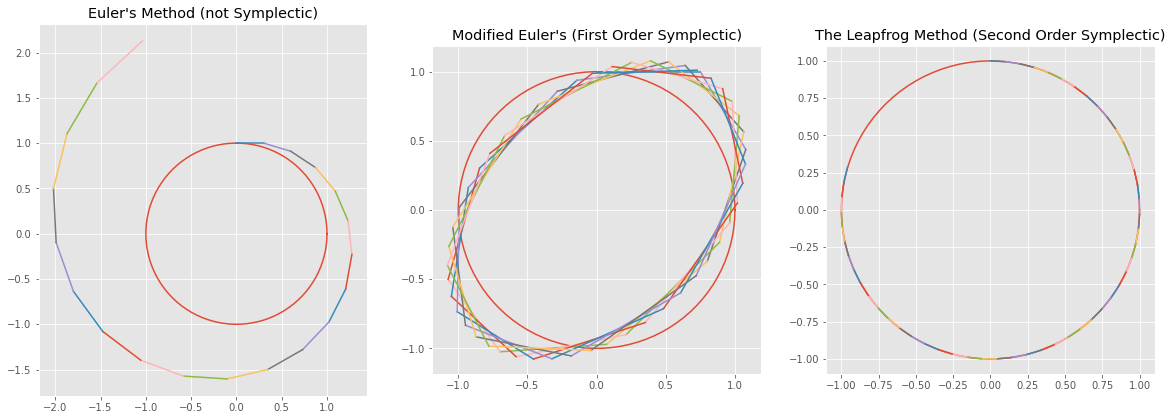

In [270]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
t = np.linspace(0,2*np.pi, 100)
for i in range(3):
  ax[i].plot(np.cos(t), -np.sin(t))
  ax[i].set_aspect('equal', adjustable='box')
  # https://www.delftstack.com/howto/matplotlib/how-to-make-a-square-plot-with-equal-axes-in-matplotlib/

theta_t, v_t, t = 0, 1, 0
epsilon = .3
ax[0].set_title("Euler's Method (not Symplectic)")
for i in range(20):
  v_t_e = v_t - epsilon * theta_t
  theta_t_e = theta_t + epsilon * v_t
  ax[0].plot([theta_t, theta_t_e], [v_t, v_t_e]) 
  theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon  

theta_t, v_t, t = 0, 1, 0
epsilon = .75
ax[1].set_title("Modified Euler's (First Order Symplectic)")
for i in range(50):
  v_t_e = v_t - epsilon * theta_t
  theta_t_e = theta_t + epsilon * v_t_e
  ax[1].plot([theta_t, theta_t_e], [v_t, v_t_e]) 
  theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon

theta_t, v_t, t = 0, 1, 0
epsilon = .1
ax[2].set_title("The Leapfrog Method (Second Order Symplectic)")
for i in range(50):
  v_t_e = v_t - epsilon / 2 * theta_t
  theta_t_e = theta_t + epsilon * v_t_e
  v_t_e = v_t_e - epsilon / 2 * theta_t_e
  ax[2].plot([theta_t, theta_t_e], [v_t, v_t_e]) 
  theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon

Notice how the errors in ***Euler's method*** compound over time. 
This is how numerical errors accumulate... they get worse and worse...

***Symplectic integrators*** such as the ***leapfrog method*** are 
- ***time-reversible***, so it is possible to "undo" calculations and return to initial values
- and (on average) maintain the energy level of the ***Hamiltonian conesrvation of energy equation***.  

The amount of "drift" a ***symplectic integrator*** has depends on its ***order***, as well as the ***time discretization step size*** of the ***integration***.

***Leapfrog integration*** is a key component of ***Hamiltonian Monte Carlo*** (***HMC***), which is a relatively recent advance in applied Bayesian analysis methodolgy which can be used to efficiently sample from (previously intractible) high dimensional distributions. ***HMC*** therefore facilitates the computation of (previously intractible) high dimensional integrals via ***Monte Carlo Integration***.

*This example is taken from Radford Neal's 2012 introduction of ***HMC*** (to the statistics community) with his seminal manuscript "MCMC using Hamiltonian dynamics", which is the recommended starting place for an introduction to ***Hamiltonian Monte Carlo*** (as opposed to, e.g., the more recent 2018 "A Conceptual Introduction to Hamiltonian Monte Carlo" manuscript from Michael Betancourt).*

<a name="cell-FPN-catacan"></a>

# 2.4 Catastrophic Cancellation ([Return to TOC](#cell-TOC)):
---

Any time a ***floating-point*** representation $[\cdot]_c$ is wrong, it's losing information:

In [268]:
1e+300 - (1e+300 + 100000000000.)

In [268]:
# That's weird/bad because `100000000000.` can of course be represented as a floating number
# plus it's a really big number... seems strange we can't keep track of it...
100000000000.

***Catastrophic cancellation*** is distinct from ***underflow***.  
- In ***underflow*** a number that is closer to $0$ than the smallest representable number is assigned a value of `0.0`
- In ***catastrophic cancellation*** the information is lost prior to arriving at `0.0`:
> Suppose two oppositely signed numbers with large magnitudes are reprsented with same absolute magnitude as a result of ***roundoff error*** so
>
>    $$|x_1| \not = |x_2| \quad \text{ but } \quad [|x_1|]_c = [|x_2|]_c$$
>
> In such situation $[x_1]_c + [x_2]_c = 0$ even if that true difference theoretically could have been sufficiently represented as a floating-point number. I.e., even if 
>    $$x_1+x_2 = [x_1+x_2]_c$$

In the example above the extra value `100000000000` is lost before the subtraction was even attempted because it cannot be kept track of relative to the significant digits in `1e+300`. Of course, this subtraction would have worked if it had been done it like this:

In [268]:
1e+300 - 1e+300 + 100000000000

<a name="cell-FPN-quadratic-formula"></a>

## The Quadratic Formula ([Return to TOC](#cell-TOC))
---

Roots of $ax^2+bx+c$ can be found with the celebrated ***quadratic formula***

$$\frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$$ 

which has real soluitions when $b^2 - 4ac \geq 0$.  However, ***roundoff error*** in $b^2-4ac$ can cause $\left[\sqrt{b^2-4ac}\right]_c = b$ which would causes ***catastrophic cancellation*** in the numerator for "$+$" solution 

$$x_1 = \frac{-b + \left[\sqrt{b^2 - 4ac}\right]_c}{2a} = 0$$. 

but would only cause ***roundoff error*** but not ***catastrophic cancellation*** in the "$-$" solution

$$x_2 = \frac{-b - \left[\sqrt{b^2 - 4ac}\right]_c}{2a} = -\frac{b}{a}$$

Using this $x_2$ solution, we can solve for $x_1$ in the product of $x_2x_1$ which can be computed by multiplying the two quadratic formula forms together and then substituting in the first $x_2$ solution (with ***roundoff error***), which yields

$$ x_1x_2 = \frac{b^2 - \left(\sqrt{b^2 - 4ac}\right)^2}{(2a)^2} = \frac{c}{a} \quad \Longrightarrow \quad x_1 = -\frac{a}{b}\frac{c}{a} = -\frac{c}{b}$$

In [268]:
a, b, c = -2, 1e+10, 100
f = lambda x: a*x**2 + b*x + c
import inspect
print(str(inspect.getsource(f)).replace('a*',str(a)).
                                replace('b*',str(b)).
                                replace('c',str(c)).
                                replace(' = lambda x:', '(x) = '))

x1 = -b + np.sqrt(b**2 - 4*a*c)
print('x1 =', x1, ': f(x1) =', f(x1))
print("This is not a root of f due to Catastrophic Cancellation\n")

x2 = -b/a
print('x2 =', x2, ': f(x2) =', f(x2))
print("This is as close as possible to a root of f due to Roundoff Error\n")

x1b = -c/b
print("x1' =", x1b, ": f(x1') =", f(x1b))
print("We can find a root of f by using a different numerical calculation!")

- This example nicely demonstrates the meaning, relevance, and applicability of author James E. Gentle's often repeated mantra:

  > *Computer numbers are not the same as real numbers, and the arithmatic operations on computer numbers are not exactly the same as those of ordinary arithmetic*. 
  >
  > *The form of a mathematical expression and the way the expression should be evaluated in practice may be quite different.*

  In any calculation we attempt we must make the problem amenable to the tools we have available.  We must identify numerical calculations that will both supply the answers we require as well as conform to the limitations and capabilities of our computational system ${\rm I\!F}$. ${\rm I\!F}$ only provides a good model to approximate ${\rm I\!R}$ if we use it appropriately.  

  *This example is inspired by the **Catastrophic Cancellation** section in Chapter 2.3 **Computer Storage and Arithmatic: Errors** following Chapter 2.2 **The Floating-Point Number System** on pages 100-101 of James E. Gentle's **Computational Statistics** textbook.*

- [Week 2 Programming Assignment Problem 2]() will examine ***catastrophic cancellation*** in the familar context of *sample sum of squares* calculations.  You may be surprised to find out that these simple and routine calculation are actually at risk for this numerical malady when ${\rm I\!F}$ is not used carefully for modeling calculations in ${\rm I\!R}$.

In [268]:
# E.g. here are two sample variance calculations that suffer
# Catastrophic Cancellation due to massive roundoff error
n = 100
from scipy import stats
x = stats.norm(loc=1e10, scale=1.).rvs(size=n)
print(x.var())
# sum_i (x_i-xbar)**2/n-1
# sum_i x_i**2 + n xbar**2 - 2 xbar sum_i x_i
# sum_i x_i**2 + n xbar**2 - 2 xbar n xbar
print( ((x**2).sum() - x.sum()**2/n)/(n-1) )
print( ((x**2).mean() - x.mean()**2)*n/(n-1) )

*This example is taken from Keith Knight's STA410 [notes1.pdf](https://q.utoronto.ca/courses/296804/files?preview=24222782) document.*

<a name="cell-DvsA"></a> 

## 2.5 [Optional] Digital Versus Analog Computing ([Return to TOC](#cell-TOC))
--- 


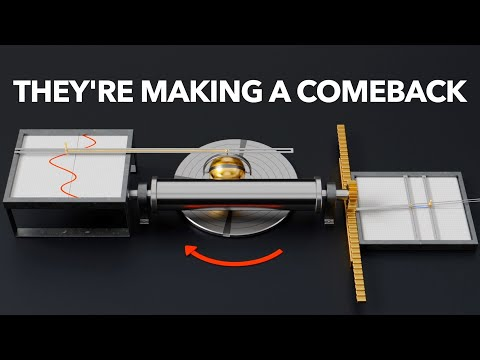

In [ ]:
from IPython.display import YouTubeVideo
# https://www.youtube.com/watch?v=IgF3OX8nT0w
YouTubeVideo('IgF3OX8nT0w', width=1024, height=512)

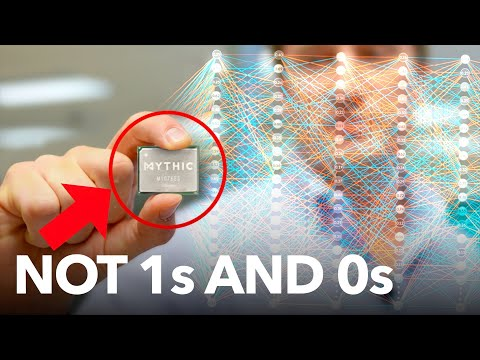

In [ ]:
# https://www.youtube.com/watch?v=GVsUOuSjvcg
YouTubeVideo('GVsUOuSjvcg', width=1024, height=512)

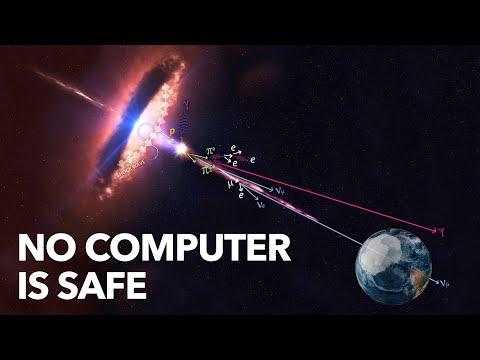

In [ ]:
# https://www.youtube.com/watch?v=AaZ_RSt0KP8
YouTubeVideo('AaZ_RSt0KP8', width=1024, height=512)

<a name="cell-FPN-bit-mult"></a>
## [OMITTED] 2.6 ~Bit Arithmetic~ ([Return to TOC](#cell-TOC))
---


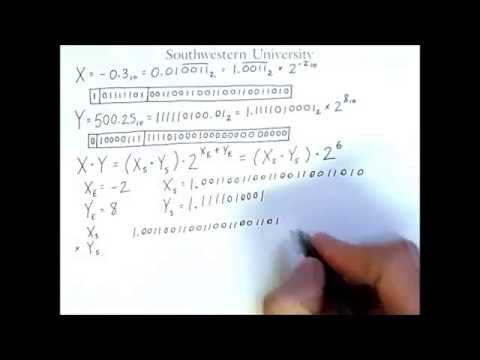

In [256]:
from IPython.display import YouTubeVideo
YouTubeVideo('27JjUa-eu_E', width=1024, height=512)


### Multiplication 

You can get a sense of arithmetic operations on bits by considering bit *multiplication* 
- $\Large \texttt{a} \times \texttt{b} = \displaystyle 2^{(\texttt{a}^{\text{expon}} - b \; + \; \texttt{b}^{\text{expon}} - b)} \times \overset{\normalsize \text{(including $sign$ bit)}}{\underbrace{\texttt{a}^{sign\text{if}} \times \texttt{b}^{sign\text{if}}}_{\normalsize \text{binary multiplication algorithm}}}$ 

  - $\texttt{a} \times \texttt{1} = \texttt{a}$: multiplying floating-point number $\texttt{a}$ by *multiplicative identity element* $\texttt{1}$ just leaves `a` as it was.
    - $\texttt{1}^{\text{expon}} = b\quad$ i.e., the *bias* $b$, since the representation of $\texttt{b}$ is *normalized*
    - $\texttt{1}^{\text{signif}} = [1.]0 \quad$ since the leading *hidden bit* is `1`

    $\require{\\cancel}\Large \texttt{a} \times \texttt{1} = \displaystyle 2^{(\texttt{a}^{\text{expon}} - b + \cancel{b - b})} \times \texttt{a}^{sign\text{if}} \times 1 = \texttt{a}$
  
  - $\texttt{a} \times \texttt{0} = \texttt{0}$: multiplying floating-point number $\texttt{a}$ by *multiplicative absorbing element* $\texttt{0}$ is $\texttt{0}$.

    - $\texttt{0}^{\text{expon}} = 0 \quad$ because $0$ is a *special reserved representation*
    - $\texttt{0}^{\text{signif}} = [0.]0 \quad$ since the leading *hidden bit* of $0$ is `0` since  $\texttt{0}^{\text{expon}} = 0$ and so $\texttt{0}^{\text{signif}}$ is *unnormalized*.

    $\Large \texttt{a} \times \texttt{0} = \displaystyle 2^{\overbrace{\texttt{a}^{\text{expon}}}^{\leq b} - b - 0 - b)} \times \texttt{a}^{sign\text{if}} \times \texttt{0} = \texttt{0}$

    since $\texttt{a}^{\text{expon}} - b - 0 \leq 0$, but the exponent cannot represent a negative number (prior to subtraction by the *bias* $b$).

### Addition

We previously added some floating-point numbers together above, but let's look closer at bit arithmetic addition

$$\Large \texttt{a}+\texttt{b} = 2^{\texttt{a}^{\text{expon}}-b} \left(\texttt{a}^{sign\text{if}} + 2^{(\texttt{b}^{\text{expon}}- \texttt{a}^{\text{expon}})} \texttt{b}^{sign\text{if}}\right) \text{ for } \texttt{a} \geq \texttt{b}$$

$$\text{and where $sign\text{if}$ means that the significand is signed.}$$

- $\texttt{b}$'s significand is first put on the same scale as $\texttt{a}$, and then added to $\texttt{a}$.

- $\texttt{a} + \texttt{0}$ = $\texttt{a}$
  - because $\texttt{0}$ has no significand bits to add to $\texttt{a}$
- $\texttt{a} + \texttt{b} = \texttt{0}$ if $\texttt{b} = -\texttt{a}$ 
  - because "$-$" flips the sign bit so then $\texttt{a} + \texttt{b} = \texttt{a} - \texttt{a}$ and so all the significand bits cancel in the subtraction

- $\texttt{a} + \texttt{b} = \texttt{a}$ any time $\texttt{b}^{\text{expon}} - \texttt{a}^{\text{expon}} \leq -52$ 

  - because there are 52 signifcand bits, and $2^{-52}$ times a signifcand shifts the bits in the significand to the right $52$ times, which replaces all significand values with `0`'s.